In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [39]:
# CZ4042 Project Part B
epochs = 1000
batch_size = 8
num_neurons = 10
seed = 10

histories={}

featnames = ['GRE Score','TOEFL Score','University Rating','SOP','LOR','CGPA','Research']

np.random.seed(seed)
tf.random.set_seed(seed)

#read and divide data into test and train sets 
admit_data = np.genfromtxt('/content/gdrive/My Drive/CZ4042 Assign1/admission_predict.csv', delimiter= ',')
X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
Y_data = Y_data.reshape(Y_data.shape[0], 1)

#shuffle the data
#idx = np.arange(X_data.shape[0])
#np.random.shuffle(idx)
#X, Y = X_data[idx], Y_data[idx]

#Split train test 70-30
#splitnum = int(0.7*(X_data.shape[0]))
#trainX_, trainY = X[:splitnum], Y[:splitnum] 
#testX_, testY = X[splitnum:], Y[splitnum:] 

trainX_, testX_, trainY, testY = train_test_split(X_data, Y_data, test_size=0.3, 
                                                  shuffle=True, random_state=seed)

scaler = StandardScaler()
trainX = scaler.fit_transform(trainX_)
testX = scaler.transform(testX_)

# Manual Standard Scaling 
#trainX = (trainX_ - np.mean(trainX_, axis=0).reshape((1,7)))/ np.std(trainX_, axis=0).reshape((1,7))
#testX = (testX_ - np.mean(trainX_, axis=0).reshape((1,7)))/ np.std(trainX_, axis=0).reshape((1,7))

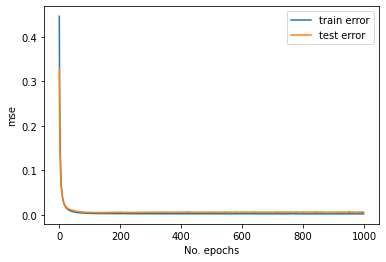

In [ ]:
# Question 1a 
starter_model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(1, activation='linear')
])

starter_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

# fit the model
histories['q1'] =starter_model.fit(trainX, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX,testY))

# plot learning curves
plt.plot(histories['q1'].history['mse'], label='train error')
plt.plot(histories['q1'].history['val_mse'], label='test error')
plt.ylabel('mse')
plt.xlabel('No. epochs')
plt.legend(loc="upper right")
plt.show()

In [ ]:
print('Min test error is %g at epoch %d ' %(np.min(histories['q1'].history['val_mse']),np.argmin(histories['q1'].history['val_mse'])) )
# From graph, test error plateaus at around epoch 125, so stop training at 125 epochs in future runs

Min test error is 0.00520794 at epoch 125 


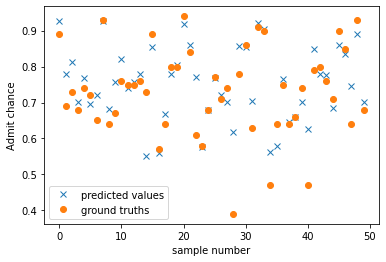

In [ ]:
# Plot predicted and target values for any 50 test samples
plt.plot(starter_model.predict(testX[20:70]),  marker = 'x', linestyle = 'None', label='predicted values')
plt.plot(testY[20:70],  marker = 'o', linestyle = 'None', label='ground truths')
plt.ylabel('Admit chance')
plt.xlabel('sample number')
plt.legend(loc="lower left")
plt.show()

In [48]:
# Creating a recursive function for RFE
def manual_rfe(trainX, trainY, testX, testY, feats = None, limit_features=5, epochs=125):
    
    if feats is None:
      feats = np.array([np.arange(1,8)])

    numfeatures = np.count_nonzero(feats)
 
    featmasks = []  # Initialize list to store feature mask arrays
    mse_list = []   # Initialize list to store mse values during feature importance ranking
    
    for idx, num in enumerate(feats[0,:]):  
        if num == 0:   # Skip already deleted features
            mse_list.append(999)
        else:
            temp_feats = feats.copy()     # Create a temp copy of the feature list 
            temp_feats[0,idx] = 0 
            newX = trainX[:, (temp_feats[0,:] > 0)]  # Apply boolean mask to get updated train data with deleted features
            newtestX = testX[:, (temp_feats[0,:] > 0)]

            tf.keras.backend.clear_session()
            tf.random.set_seed(10)

            model = keras.Sequential([
                keras.layers.Dense(num_neurons, activation='relu',
                                  kernel_regularizer=keras.regularizers.l2(1e-3)),
                keras.layers.Dense(1, activation='linear')])

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                          loss=keras.losses.MeanSquaredError(),
                          metrics=['mse'])
            
            history = model.fit(newX, trainY,
                      epochs=epochs,          # Test using 125 epochs to get mse for each case of removed feature
                      batch_size=8,
                      shuffle=True,
                      verbose = 0,
                      validation_data=(newtestX, testY))        # validate on test set ... data leak?
            
#            mse_list.append(np.min(history.history['val_mse']))  # Use min val_mse as metric for 'feature importance'
            mse_list.append(history.history['val_mse'][-1])      # Use last epoch val_mse

    feats[0,np.argmin(mse_list)] = 0    # after removal of the least important feature should result in the minimum val_mse
    featmasks.append(feats[0,:].copy() > 0)

    print('Deleted feature at column index: %d - %s' %(np.argmin(mse_list), featnames[np.argmin(mse_list)]))
    print(mse_list)
    print(feats)
    print('--')
    
    if numfeatures > limit_features + 1:
        featmasks.append(manual_rfe(trainX, trainY, testX, testY, feats)[0])

    return featmasks


In [52]:
# Perform RFE, generate feature masks
featmasks = manual_rfe(trainX, trainY, testX, testY, limit_features=5, epochs=125)

Deleted feature at column index: 6 - Research
[0.005800977349281311, 0.006033737678080797, 0.005243420600891113, 0.005909222178161144, 0.005464253015816212, 0.005956660490483046, 0.005130513571202755]
[[1 2 3 4 5 6 0]]
--
Deleted feature at column index: 4 - LOR
[0.005496865138411522, 0.005628127139061689, 0.005491228774189949, 0.005481598433107138, 0.005207574460655451, 0.006503914017230272, 999]
[[1 2 3 4 0 6 0]]
--


In [53]:
# Get performance of the different feature sets
epochs = 125
performance = []

sixfeat_mask = featmasks[0]
fivefeat_mask = featmasks[1]

# Check to see if correct features are being removed
print('First deleted column index: %d - %s' %(np.argmin(sixfeat_mask), featnames[np.argmin(sixfeat_mask)]))
print('Second deleted column index: %d - %s' %(np.argmax(np.logical_xor(sixfeat_mask,fivefeat_mask)), featnames[np.argmax(np.logical_xor(sixfeat_mask,fivefeat_mask))]) )

# All 7 features 
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

history = model.fit(trainX, trainY,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose = 0,
                    validation_data=(testX,testY))

performance.append(history.history['val_mse'][-1])

# 6 features 
trainX_new = trainX[:,sixfeat_mask]
testX_new = testX[:,sixfeat_mask]

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

history = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

performance.append(history.history['val_mse'][-1])

# 5 features
trainX_new = trainX[:,fivefeat_mask]
testX_new = testX[:,fivefeat_mask]

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

history = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

#performance.append(np.min(history.history['val_mse']))
performance.append(history.history['val_mse'][-1])

print(performance)

First deleted column index: 6 - Research
Second deleted column index: 4 - LOR
[0.005219010636210442, 0.005130513571202755, 0.005207574460655451]


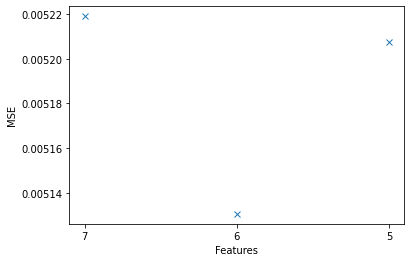

In [54]:
# Plot performance
plt.plot(['7','6','5'], performance, marker = 'x', linestyle = 'None', label='test mse')
plt.ylabel('MSE')
plt.xlabel('Features')
plt.show()

# MSE improves slightly when using 6 features, but worsens when using 5 features. Hence we will use 6 features since it has min MSE.

In [119]:
# Qn 3: using optimized feature set -> 4 layer, 5 layer, 4 layer with dropout, 5 layer with dropout, compare with 3 layer

trainX_new = trainX[:,sixfeat_mask]  # 6 feature set is best
testX_new = testX[:,sixfeat_mask]
performance3 = []  # 3 layer, 4 layer, 5 layer, 4 + dropout, 5 + dropout
histories_q3 = {}

# 3 Layer Model
epochs = 125  
num_neurons = 10 

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),                      
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

histories_q3['3layer'] = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

performance3.append(np.min(histories_q3['3layer'].history['val_mse']))   # Compare at final epoch val_mse
print(performance3)

[0.005121840164065361]


In [120]:
# 4 Layer Model
num_neurons = 50 

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),                       
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

histories_q3['4layer'] = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

performance3.append(np.min(histories_q3['4layer'].history['val_mse']))   # Compare at final epoch val_mse
print(performance3)

[0.005121840164065361, 0.005187126807868481]


In [121]:
# 5 Layer Model
num_neurons = 50 

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),                                                
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

histories_q3['5layer'] = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

performance3.append(np.min(histories_q3['5layer'].history['val_mse']))
print(performance3)

[0.005121840164065361, 0.005187126807868481, 0.005095324944704771]


In [122]:
# 4 Layer Model with Dropout
num_neurons = 50 

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dropout(0.2),  # Keep Prob = 0.8, so dropout rate = 0.2
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)), 
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

histories_q3['4dropout'] = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

performance3.append(np.min(histories_q3['4dropout'].history['val_mse']))
print(performance3)

[0.005121840164065361, 0.005187126807868481, 0.005095324944704771, 0.005166288930922747]


In [123]:
# 5 Layer Model with Dropout
num_neurons = 50 

tf.keras.backend.clear_session()
tf.random.set_seed(seed)

model = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dropout(0.2),                      
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-3)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])

histories_q3['5dropout'] = model.fit(trainX_new, trainY,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        verbose = 0,
                                        validation_data=(testX_new,testY))

performance3.append(np.min(histories_q3['5dropout'].history['val_mse']))

print('3, 4, 5, 4+dropout, 5+dropout')
print(performance3)

3, 4, 5, 4+dropout, 5+dropout
[0.005121840164065361, 0.005187126807868481, 0.005095324944704771, 0.005166288930922747, 0.005095476750284433]


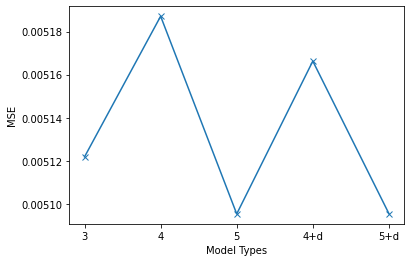

In [124]:
# Plot performance across different models
plt.plot(['3', '4', '5', '4+d', '5+d'], performance3, marker = 'x', label='test mse')
plt.ylabel('MSE')
plt.xlabel('Model Types')
plt.show()


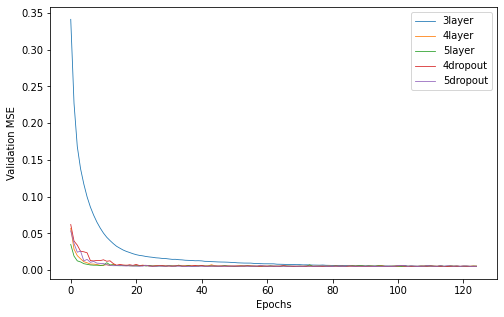

In [125]:
# Plot val mses 
plt.figure(figsize=(8,5))
for model in ['3layer','4layer','5layer','4dropout','5dropout']:
  plt.plot(histories_q3[model].history['val_mse'], label=model, linewidth=0.8)
plt.ylabel('Validation MSE')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()